# Experimental results

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tables as tb
import time
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Initial data

In [2]:
farm_names = ['Oahu', 'Almeria']
farm_names_es = ['Oahu', 'Almería']
input_paths = []
sensor_names = {}
sensor_latitudes = {}
sensor_longitudes = {}
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    input_path = f'../data/input/{farm_name}/sensors_data.h5'
    input_paths.append(input_path)
    input_table = tb.open_file(input_path, 'r')
    info_group = input_table.get_node('/', 'info')
    sensor_names_aux: tb.Array = input_table.get_node(info_group, 'sensor_names')
    sensor_names[farm_name] = [name.decode() for name in sensor_names_aux]
    sensor_latitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_latitudes')
    sensor_longitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_longitudes')
    input_table.close()
output_paths = ['../data/output/DataCenter/Oahu/oahu.h5', '../data/output/DataCenter/Almeria/almeria.h5']

## Monitoring

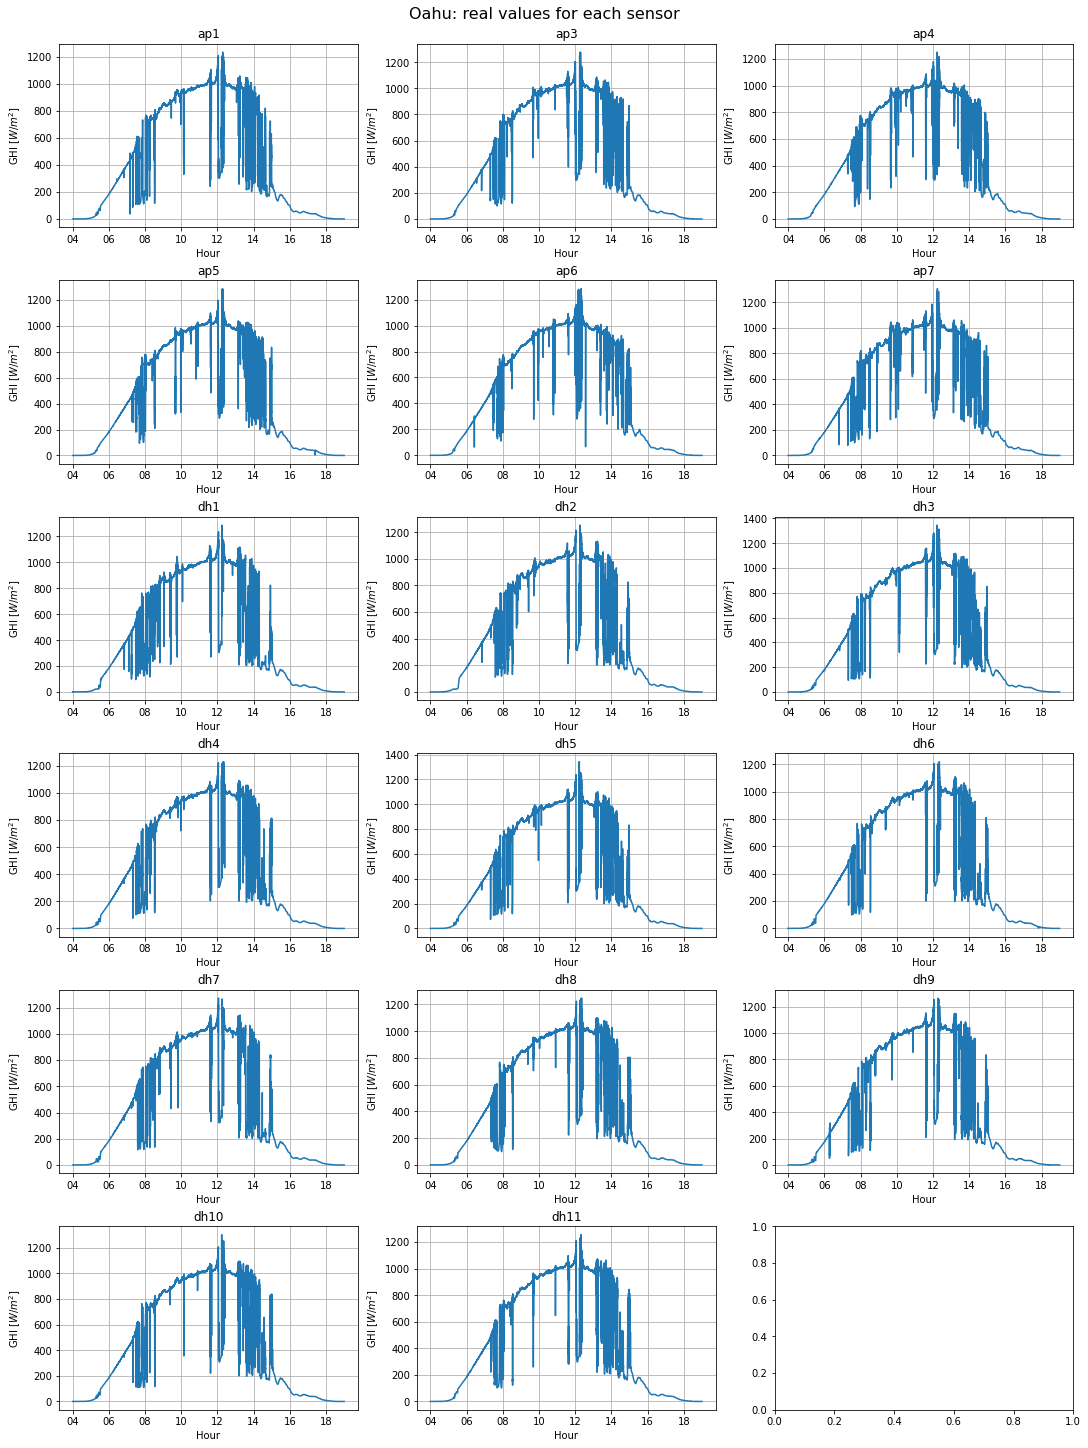

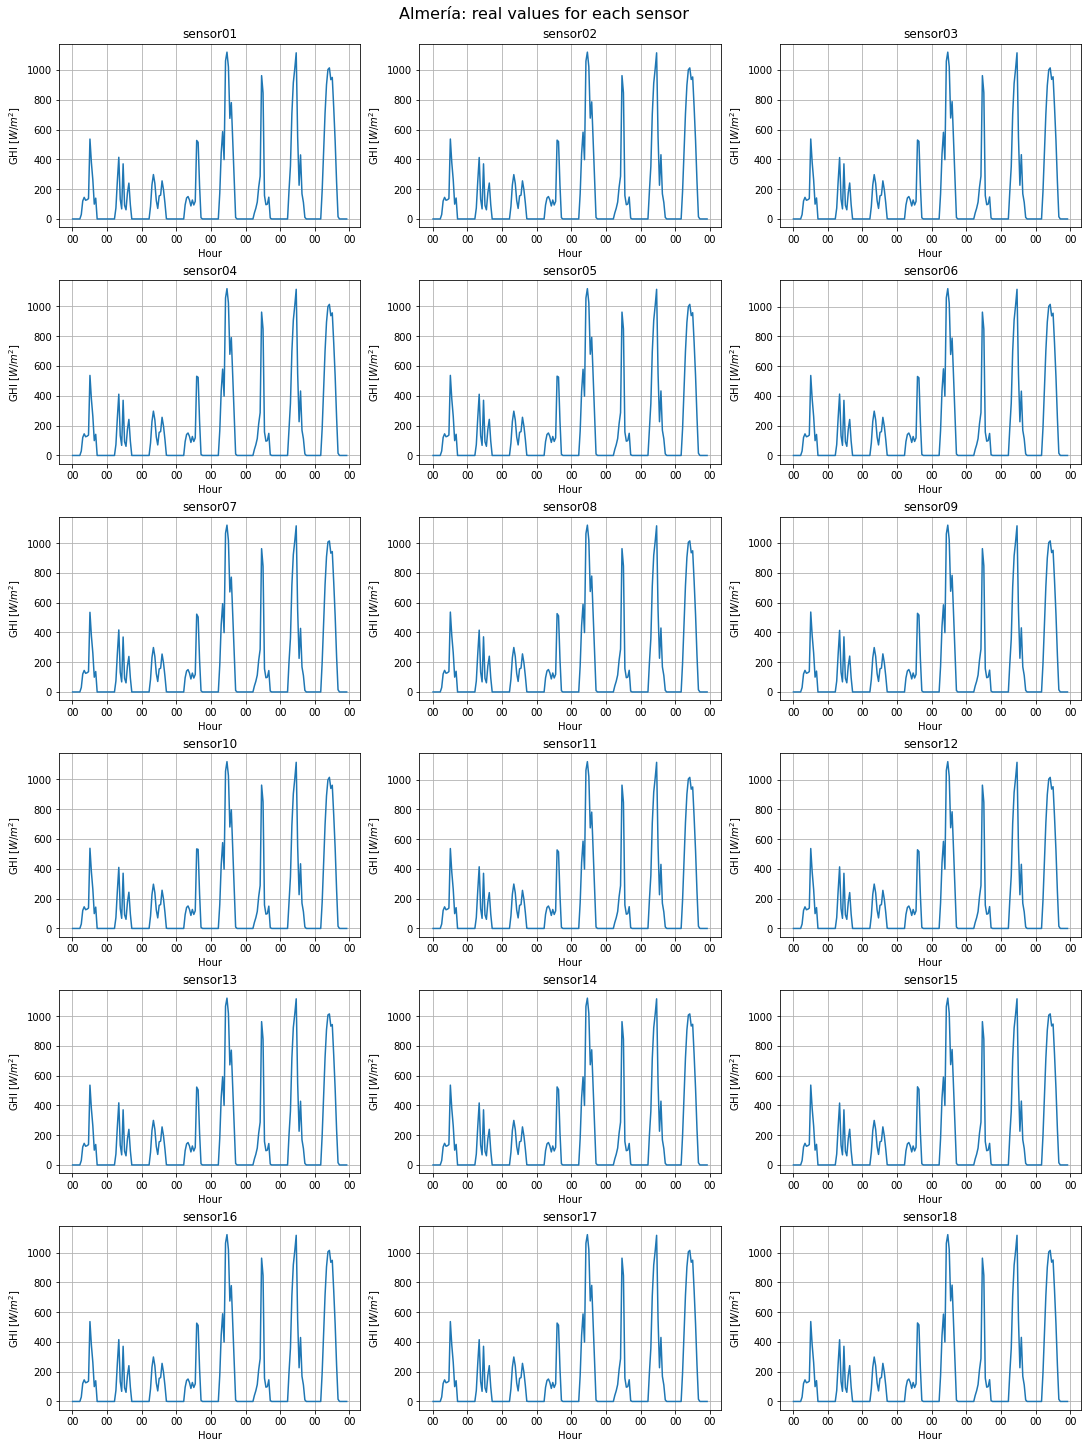

In [10]:
start_dts = [dt.datetime.strptime("2010-06-27 00:00:00", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-22 00:00:01", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-06-27 23:59:59", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-29 23:59:59", "%Y-%m-%d %H:%M:%S")]
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    output_path = output_paths[f]
    output_table = tb.open_file(output_path, 'r')
    fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
    fig.suptitle(f'{farm_names_es[f]}: real values for each sensor', fontsize=16)
    for s in range(len(sensor_names[farm_name])):
        sensor_table = output_table.get_node(f'/DataCenter/{farm_name}/{sensor_names[farm_name][s]}')
        df = pd.DataFrame.from_records(sensor_table.read_where(f"(timestamp>={start_dts[f].timestamp()}) & (timestamp<{stop_dts[f].timestamp()})"))
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        ax[s//3,s%3].set_title(sensor_names[farm_name][s])
        ax[s//3,s%3].plot(df.timestamp, df.radiation)
        ax[s//3,s%3].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax[s//3,s%3].grid()
        ax[s//3,s%3].set_ylabel('GHI $[W/m^2]$')
        ax[s//3,s%3].set_xlabel('Hour') #, fontsize=12)
    fig.savefig(f'{farm_names[f]}-monitoring.png', dpi=400, bbox_inches='tight')
    output_table.close()

## Outliers detection

18:16:58 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the model is 58.35202433934863
The MAPE for the model is 1633494165911617.0


18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the model is 134.9279099807637
The MAPE for the model is 1.4763670722783088e+17


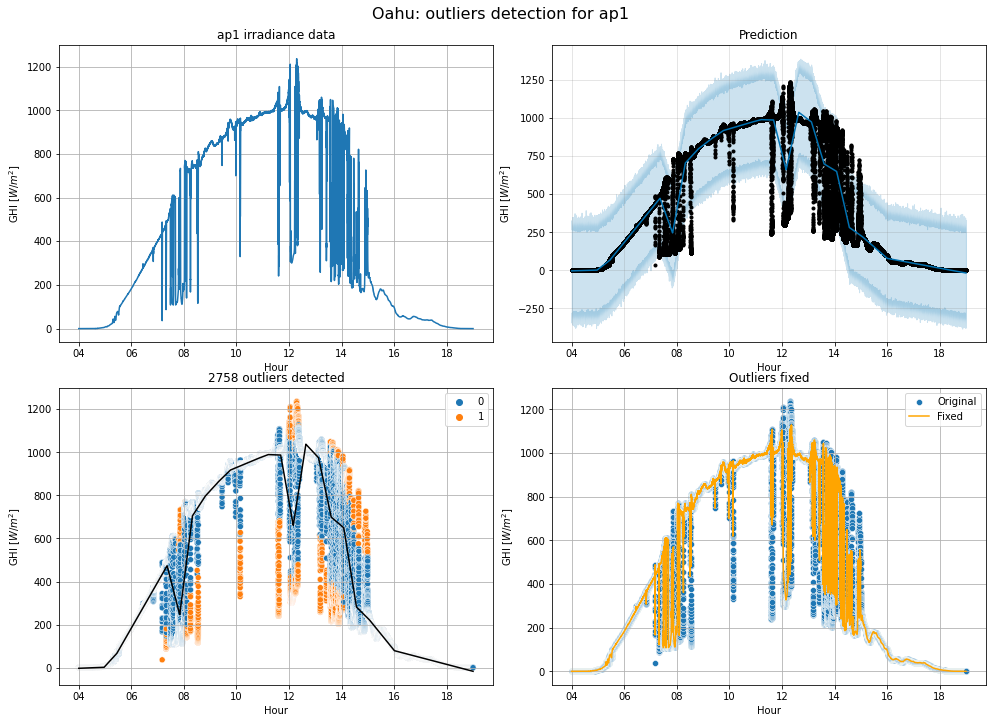

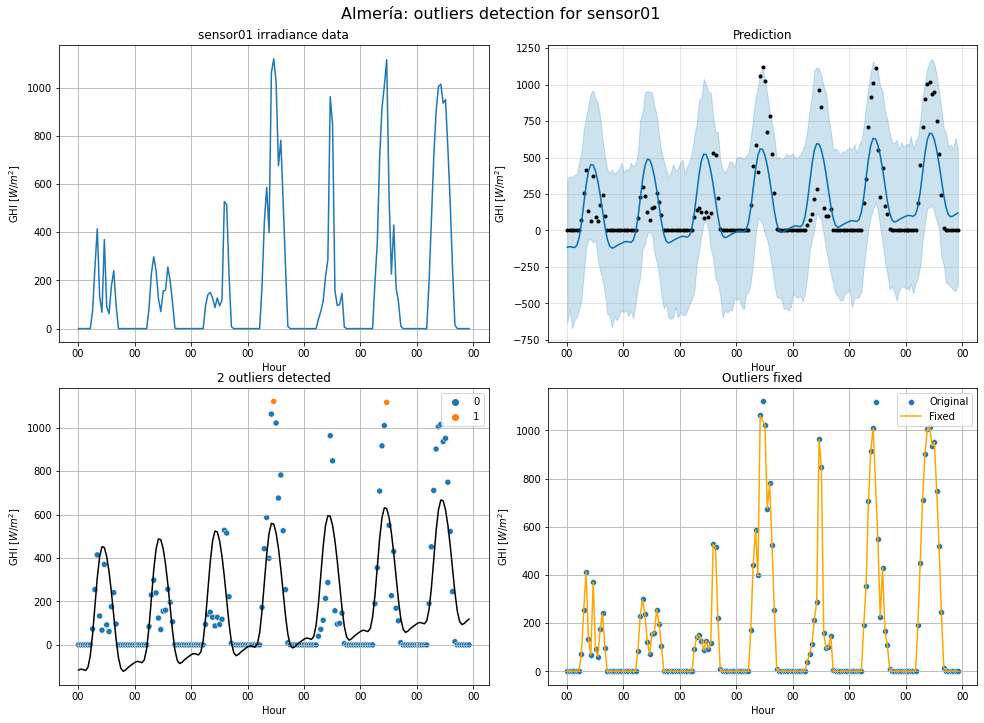

In [11]:
sensors_test = ['ap1', 'sensor01']
start_dts = [dt.datetime.strptime("2010-06-27 00:00:01", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-22 23:59:59", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-06-27 23:59:59", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-29 23:59:59", "%Y-%m-%d %H:%M:%S")]
for f in range(2):
    h5 = tb.open_file(output_paths[f], 'r')
    sensor_table = h5.get_node(f'/DataCenter/{farm_names[f]}/{sensors_test[f]}')
    df = pd.DataFrame.from_records(sensor_table.read_where(f"(timestamp>={start_dts[f].timestamp()}) & (timestamp<{stop_dts[f].timestamp()})"))
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Preparing the model ..."
    data = df.rename(columns={"timestamp": "ds", "radiation": "y"})
    model = Prophet(interval_width=0.99)
    try:
        model.fit(data)
    except:
        print(f"Error: Prophet model for {farm_names[f]}[{sensors_test[f]}] could not be fitted")
        h5.close()
        continue

    fig, ax = plt.subplots(2,2, figsize=(14,10))
    fig.suptitle(f'{farm_names_es[f]}: outliers detection for {sensors_test[f]}', fontsize=16)
    ax[0,0].set_title(f'{sensors_test[f]} irradiance data')
    ax[0,0].plot(df.timestamp, df.radiation)
    ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[0,0].grid()
    ax[0,0].set_ylabel('GHI $[W/m^2]$')
    ax[0,0].set_xlabel('Hour') #, fontsize=12)

    # Making prediction ...
    forecast = model.predict(data)
    model.plot(forecast, ax=ax[0,1])
    ax[0,1].set_title('Prediction')
    ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[0,1].set_ylabel('GHI $[W/m^2]$')
    ax[0,1].set_xlabel('Hour') #, fontsize=12)

    # Merge actual and predicted values, show MAE and MAPE
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')
    
    # Create an anomaly indicator. Visualize
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
    num_outliers = performance['anomaly'].value_counts()[1]
    sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly', ax=ax[1,0])
    sns.lineplot(x='ds', y='yhat', data=performance, color='black', ax=ax[1,0])
    ax[1,0].set_title(f'{num_outliers} outliers detected')
    ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[1,0].grid()
    ax[1,0].set_ylabel('GHI $[W/m^2]$')
    ax[1,0].set_xlabel('Hour') #, fontsize=12)
    
    # Compute fixed values
    df_fixed = df.copy()
    df_fixed.reset_index(inplace=True)
    idx = performance.index[performance['anomaly'] == 1].tolist()
    for id in idx:
        df_fixed.loc[id, 'radiation'] = np.nan
    df_fixed['radiation'].interpolate(method="linear", inplace=True)
    sns.scatterplot(x='timestamp', y='radiation', data=df, label='Original', ax=ax[1,1])
    sns.lineplot(x='timestamp', y='radiation', data=df_fixed, color='orange', label='Fixed', ax=ax[1,1])
    ax[1,1].set_title(f'Outliers fixed')
    ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[1,1].grid()
    ax[1,1].set_ylabel('GHI $[W/m^2]$')
    ax[1,1].set_xlabel('Hour') #, fontsize=12)

    fig.savefig(f'{farm_names[f]}-outliers.png', dpi=400, bbox_inches='tight')
    h5.close()